In [1]:
import os
import math
from time import time
from timeit import timeit 
from timeit import Timer
import ROOT
import vector as vec
import numpy as np
import numba as nb
import awkward as ak
from matplotlib import pyplot as plt
import mplhep 
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})
plt.style.use(mplhep.style.CMS)

Welcome to JupyROOT 6.16/00


In [2]:
# run this cell after running build_fastmtt.py in the fastmtt_classic/ directory
fastmtt_dir = 'fastmtt_classic/'
for basename in ['MeasuredTauLepton', 'svFitAuxFunctions', 'FastMTT']:
    path = fastmtt_dir + basename
    print(path)
    if os.path.isfile("{0:s}_cc.so".format(path)):
        ROOT.gInterpreter.ProcessLine(".L {0:s}_cc.so".format(path))
    else:
        ROOT.gInterpreter.ProcessLine(".L {0:s}.cc++".format(path))

fastmtt_classic/MeasuredTauLepton
fastmtt_classic/svFitAuxFunctions
fastmtt_classic/FastMTT


cling::DynamicLibraryManager::loadLibrary(): /uscms_data/d3/jdezoort/AZh_columnar/CMSSW_10_2_9/src/fastmtt/fastmtt_classic/MeasuredTauLepton_cc.so: undefined symbol: _ZN13classic_svFit14roundToNdigitsEdi


In [3]:
# import FastMTT, check that it's set up correctly
from ROOT import FastMTT
FastMTT()

In [4]:
# function to test the classic fastmtt algorithm performance
def fastmtt_classic(pt_1, eta_1, phi_1, mass_1, decay_type_1,
                    pt_2, eta_2, phi_2, mass_2, decay_type_2,
                    met_x, met_y, 
                    metcov_xx, metcov_xy, metcov_yx, metcov_yy):
    
    # initial mass quantities and arrays
    ele_mass, mu_mass = 0.511*10**-3, 0.105
    m_tt_opt = np.zeros(N) # corrected m_tt
    m_tt_vis = np.zeros(N) # raw (visible) m_tt
    
    # instantiate an instance of ROOT.FastMTT()
    fastmtt = FastMTT()
    for i in range(N):
        
        # we're only examining Z->ee, H->tau(mu)tau(had)
        category = 'eemt'

        # arrange the ditau system's four-vectors
        t1, t2 = ROOT.TLorentzVector(), ROOT.TLorentzVector()
        t1.SetPtEtaPhiM(pt_1[i], eta_1[i],
                        phi_1[i], mass_1[i])
        t2.SetPtEtaPhiM(pt_2[i], eta_2[i],
                        phi_2[i], mass_2[i])
        #m_tt_vis[i] = (t1 + t2).M()
    
        # build ROOT containers for met covariance, ditau pair
        METcov = ROOT.TMatrixD(2,2)
        tau_vector = ROOT.std.vector('MeasuredTauLepton')
        tau_pair = tau_vector()
        
        # fill met quantities
        METx, METy = metx[i], mety[i]
        METcov[0][0] = metcov_xx[i]
        METcov[0][1] = metcov_xy[i]
        METcov[1][0] = metcov_yx[i]
        METcov[1][1] = metcov_yy[i]

        # label tau decay modes 
        ele_decay = ROOT.MeasuredTauLepton.kTauToElecDecay
        mu_decay  = ROOT.MeasuredTauLepton.kTauToMuDecay
        had_decay = ROOT.MeasuredTauLepton.kTauToHadDecay

        # add tau(mu) and tau(had) decays to the ditau pair
        tau_mu = ROOT.MeasuredTauLepton(mu_decay, t1.Pt(),
                                        t1.Eta(), t1.Phi(), mu_mass)
        tau_pair.push_back(tau_mu)
        tau_had = ROOT.MeasuredTauLepton(had_decay, t2.Pt(),
                                         t2.Eta(), t2.Phi(), t2.M())
        tau_pair.push_back(tau_had)
        
        # store relevant mass quantities
        m_tt_vis[i] = (tau_pair[0].p4() + tau_pair[1].p4()).M()
          
        # run the classic fastmtt implementation
        fastmtt.run(tau_pair, METx, METy, METcov, False)
        diTau_p4 = fastmtt.getBestP4()
        m_tt_opt[i] = diTau_p4.M() #tt_p4.M()

    return {'m_tt_vis': m_tt_vis,
            'm_tt_opt': m_tt_opt}

In [5]:
@nb.jit(nopython=True, parallel=False)
def fastmtt_numba(pt_1, eta_1, phi_1, mass_1, decay_type_1,
                  pt_2, eta_2, phi_2, mass_2, decay_type_2,
                  met_x, met_y, metcov_xx, metcov_xy, metcov_yx, metcov_yy,
                  verbosity=-1, delta=1/1.15, reg_order=6,
                  constrain=False, 
                  constraint_window=np.array([124,126])):
        
    # initialize global parameters
    m_ele = 0.51100e-3
    m_muon = 0.10566
    m_tau = 1.77685
    m_pion = 0.13957
    mass_dict = {0: m_ele, 1: m_muon}
    
    # initialize higgs->ditau decays, tau decay types
    N = len(pt_1)
    m_tt_vis = np.zeros(N, dtype=np.float32)
    m_tt_opt = np.zeros(N, dtype=np.float32)

    # loop over all events, calculate corrected ditau mass
    for i in range(N):
        
        # grab the correct masses based on tau decay type
        # tau decay_type: 0 ==> leptonic to electron, 
        #                 1 ==> leptonic to muon, 
        #                 2 ==> leptonic to hadronic
        if (decay_type_1[i] != 2): m1 = mass_dict[decay_type_1[i]]
        else: m1 = mass1[i]
        if (decay_type_2[i] != 2): m2 = mass_dict[decay_type_2[i]]
        else: m2 = mass2[i]
            
        # store visible masses
        m_vis_1 = m1
        m_vis_2 = m2
        
        # determine minimum and maximum possible masses
        m_vis_min_1, m_vis_max_1 = 0, 0
        m_vis_min_2, m_vis_max_2 = 0, 0
        if (decay_type_1[i] == 0): m_vis_min_1, m_vis_max_1 = m_ele, m_ele
        if (decay_type_1[i] == 1): m_vis_min_1, m_vis_max_1 = m_muon, m_muon
        if (decay_type_1[i] == 2): m_vis_min_1, m_vis_max_1 = m_pion, 1.5
        if (decay_type_2[i] == 0): m_vis_min_2, m_vis_max_2 = m_ele, m_ele
        if (decay_type_2[i] == 1): m_vis_min_2, m_vis_max_2 = m_muon, m_muon
        if (decay_type_2[i] == 2): m_vis_min_2, m_vis_max_2 = m_pion, 1.5
        if (m_vis_1 < m_vis_min_1): m_vis_1 = m_vis_min_1
        if (m_vis_1 > m_vis_max_1): m_vis_1 = m_vis_max_1
        if (m_vis_2 < m_vis_min_2): m_vis_2 = m_vis_min_2
        if (m_vis_2 > m_vis_max_2): m_vis_2 = m_vis_max_2
          
        # store both tau candidate four vectors
        leg1 = vec.obj(pt=pt_1[i], eta=eta_1[i], phi=phi_1[i], mass=m_vis_1)
        leg2 = vec.obj(pt=pt_2[i], eta=eta_2[i], phi=phi_2[i], mass=m_vis_2)

        # store visible mass of ditau pair
        m_vis = math.sqrt(2*leg1.pt*leg2.pt*(math.cosh(leg1.eta - leg2.eta) - 
                                             math.cos(leg1.phi - leg2.phi)))
        m_tt_vis[i] = m_vis
            
        # correct initial visible masses
        if (decay_type_1[i] == 2 and m_vis_1 > 1.5): m_vis_1 = 0.3
        if (decay_type_2[i] == 2 and m_vis_2 > 1.5): m_vis_2 = 0.3

        # invert met covariance matrix, calculate determinant
        metcovinv_xx, metcovinv_yy = metcov_yy[i], metcov_xx[i]
        metcovinv_xy, metcovinv_yx = -metcov_xy[i], -metcov_yx[i]
        metcovinv_det = (metcovinv_xx*metcovinv_yy -
                         metcovinv_yx*metcovinv_xy)
        if (metcovinv_det<1e-10): 
                print("Warning! Ill-conditioned MET covariance at event index", i)
                continue
               
        # perform likelihood scan 
        # see http://cms.cern.ch/iCMS/jsp/openfile.jsp?tp=draft&files=AN2019_032_v3.pdf
        met_const = 1/(2*math.pi*math.sqrt(metcovinv_det))
        min_likelihood, x1_opt, x2_opt = 999, 0, 0
        mass_likelihood, met_transfer = 0, 0
        
        # scan over weights for each ditau four-vector
        for x1 in np.arange(0, 1, 0.01):
            for x2 in np.arange(0, 1, 0.01):
                x1_min = min(1, math.pow((m_vis_1/m_tau), 2))
                x2_min = min(1, math.pow((m_vis_2/m_tau),2))
                if ((x1 < x1_min) or (x2 < x2_min)): 
                    continue
        
                # test weighted four-vectors
                leg1_x1, leg2_x2 = leg1*(1/x1), leg2*(1/x2)
                ditau_test = vec.obj(px=leg1_x1.px+leg2_x2.px,
                                     py=leg1_x1.py+leg2_x2.py,
                                     pz=leg1_x1.pz+leg2_x2.pz,
                                     E=leg1_x1.E+leg2_x2.E)
                nu_test = vec.obj(px=ditau_test.px-leg1.px-leg2.px, 
                                  py=ditau_test.py-leg1.py-leg2.py,
                                  pz=ditau_test.pz-leg1.pz-leg2.pz,
                                  E=ditau_test.E-leg1.E-leg2.E)
                test_mass = ditau_test.mass
                if (((test_mass < constraint_window[0]) or
                     (test_mass > constraint_window[1])) and
                    constrain): continue 
            
                # calculate mass likelihood integral 
                m_shift = test_mass * delta
                if (m_shift < m_vis): continue 
                x1_min = min(1.0, math.pow((m_vis_1/m_tau),2))
                x2_min = max(math.pow((m_vis_2/m_tau),2), 
                             math.pow((m_vis/m_shift),2))
                x2_max = min(1.0, math.pow((m_vis/m_shift),2)/x1_min)
                if (x2_max < x2_min): continue
                J = 2*math.pow(m_vis,2) * math.pow(m_shift, -reg_order)
                I_x2 = math.log(x2_max) - math.log(x2_min)
                I_tot = I_x2
                if (decay_type_1[i] != 2):
                    I_m_nunu_1 = math.pow((m_vis/m_shift),2) * (math.pow(x2_max,-1) - math.pow(x2_min,-1))
                    I_tot += I_m_nunu_1
                if (decay_type_2[i] != 2):
                    I_m_nunu_2 = math.pow((m_vis/m_shift),2) * I_x2 - (x2_max - x2_min)
                    I_tot += I_m_nunu_2
                mass_likelihood = 1e9 * J * I_tot
                
                # calculate MET transfer function 
                residual_x = met_x[i] - nu_test.x
                residual_y = met_y[i] - nu_test.y
                pull2 = (residual_x*(metcovinv_xx*residual_x + 
                                     metcovinv_xy*residual_y) +
                         residual_y*(metcovinv_yx*residual_x +
                                     metcovinv_yy*residual_y))
                pull2 /= metcovinv_det
                met_transfer = met_const*math.exp(-0.5*pull2)
                
                # calculate final likelihood, store if minimum
                likelihood = -met_transfer * mass_likelihood 
                if (likelihood < min_likelihood):
                    min_likelihood = likelihood
                    x1_opt, x2_opt = x1, x2
                
        leg1_x1, leg2_x2 = leg1*(1/x1_opt), leg2*(1/x2_opt)
        p4_ditau_opt = vec.obj(px=leg1_x1.px+leg2_x2.px,
                               py=leg1_x1.py+leg2_x2.py,
                               pz=leg1_x1.pz+leg2_x2.pz,
                               E=leg1_x1.E+leg2_x2.E)
        m_tt_opt[i] = p4_ditau_opt.mass
            
    return {'m_tt_vis': m_tt_vis,
            'm_tt_opt': m_tt_opt}

In [6]:
infile = np.load('samples/AZh_M220GeV_eemt.npz')
print(infile.files)

N = 5000
pt1, pt2 = infile['pt3'][:N], infile['pt4'][:N]
eta1, eta2 = infile['eta3'][:N], infile['eta4'][:N]
phi1, phi2 = infile['phi3'][:N], infile['phi4'][:N]
mass1, mass2 = infile['mass3'][:N], infile['mass4'][:N]
decay_type_1 = np.ones(len(pt1), dtype=np.uint8)[:N]
decay_type_2 = 2*np.ones(len(pt1), dtype=np.uint8)[:N]
metx, mety = infile['METx'][:N], infile['METy'][:N]
metcov_xx = infile['METcov_00'][:N]
metcov_xy = infile['METcov_01'][:N]
metcov_yx = infile['METcov_10'][:N]
metcov_yy = infile['METcov_11'][:N]

print("Computing fastmtt numba")
out_numba = fastmtt_numba(pt1, eta1, phi1, mass1, decay_type_1,
                          pt2, eta2, phi2, mass2, decay_type_2,
                          metx, mety, 
                          metcov_xx, metcov_xy, metcov_yx, metcov_yy,
                          verbosity=-1, delta=1/1.15, reg_order=6)

print("Computing fastmtt classic")
out_classic = fastmtt_classic(pt1, eta1, phi1, mass1, decay_type_1,
                              pt2, eta2, phi2, mass2, decay_type_2,
                              metx, mety, 
                              metcov_xx, metcov_xy, metcov_yx, metcov_yy)

['lumi', 'evt', 'category', 'pt1', 'pt2', 'pt3', 'pt4', 'eta1', 'eta2', 'eta3', 'eta4', 'phi1', 'phi2', 'phi3', 'phi4', 'mass3', 'mass4', 'METx', 'METy', 'METcov_00', 'METcov_01', 'METcov_10', 'METcov_11']
Computing fastmtt numba
Computing fastmtt classic


In [7]:
t = Timer(lambda: fastmtt_numba(pt1, eta1, phi1, mass1, decay_type_1,
                                pt2, eta2, phi2, mass2, decay_type_2,
                                metx, mety, 
                                metcov_xx, metcov_xy, metcov_yx, metcov_yy,
                                verbosity=-1, delta=1/1.15, reg_order=6))

niter = 3
fastmtt_numba_time = t.timeit(number=niter)
print(f"fastmtt numba completed in {fastmtt_numba_time:.3f}s")
print(f"time per sample: {fastmtt_numba_time/niter/N:.5f}s")

fastmtt numba completed in 50.607s
time per sample: 0.00337s


In [8]:
t = Timer(lambda: fastmtt_classic(pt1, eta1, phi1, mass1, decay_type_1,
                                  pt2, eta2, phi2, mass2, decay_type_2,
                                  metx, mety, 
                                  metcov_xx, metcov_xy, metcov_yx, metcov_yy))

fastmtt_classic_time = t.timeit(number=niter)
print(f"fastmtt classic completed in {fastmtt_classic_time:.3f}s")
print(f"time per sample: {fastmtt_classic_time/niter/N:.5f}s")

fastmtt classic completed in 37.887s
time per sample: 0.00253s


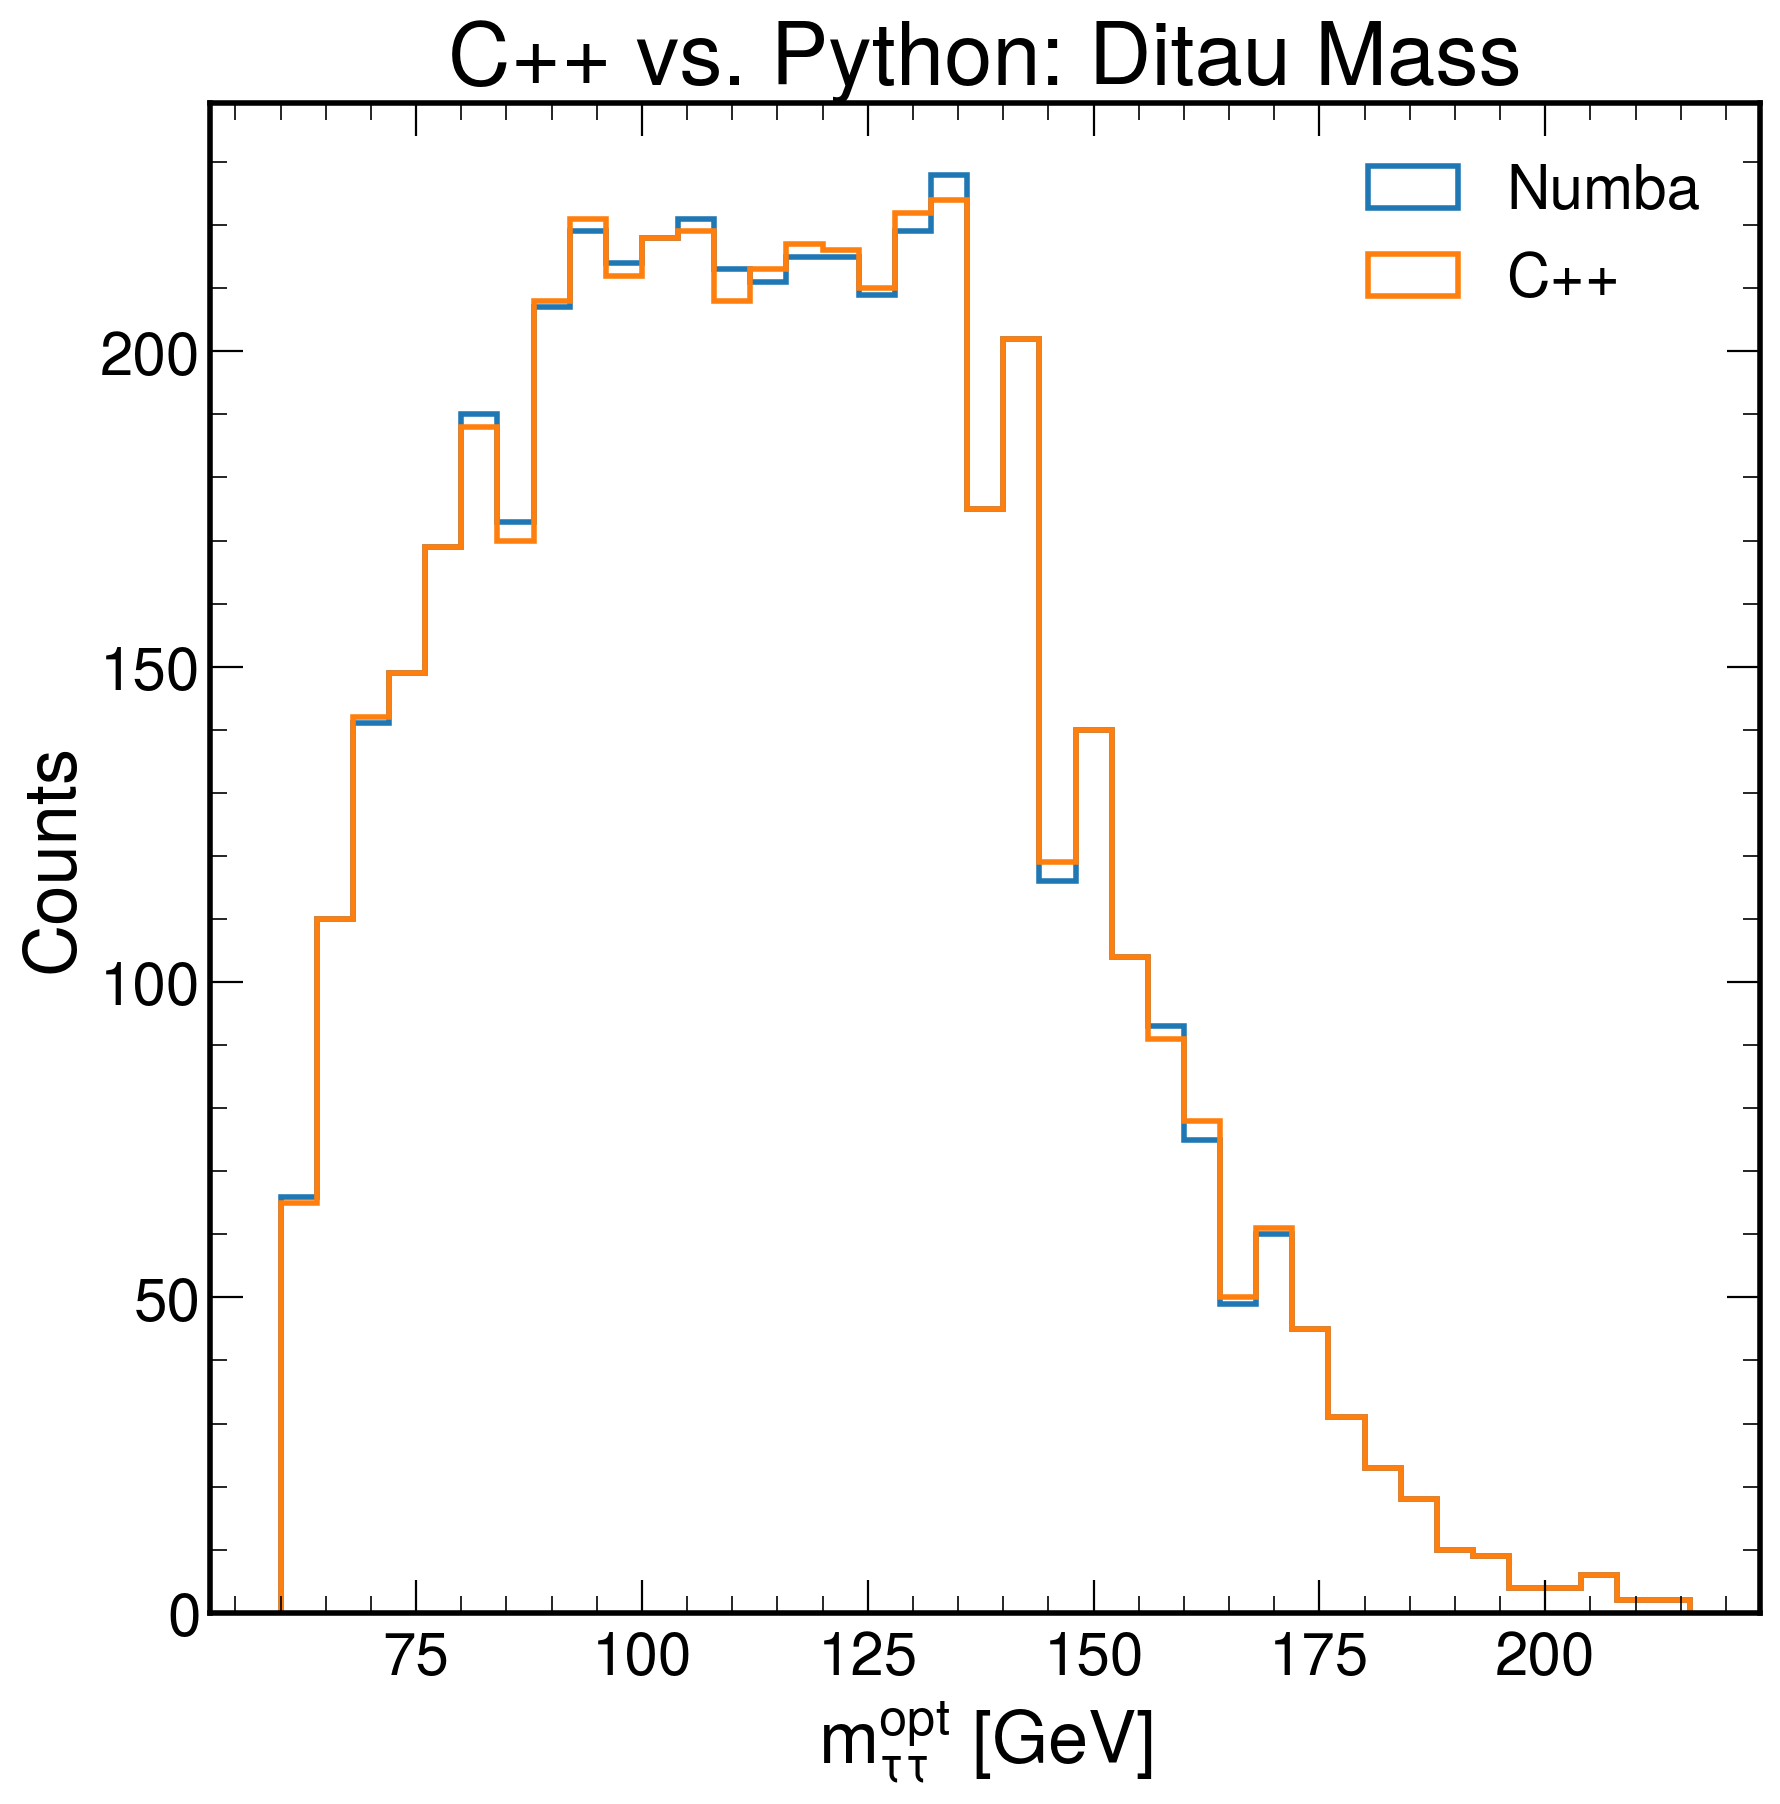

In [14]:
# plot the ditau mass distributions 
fig = plt.figure(dpi=200)
plt.title("C++ vs. Python: Ditau Mass")
plt.ylabel('Counts')
plt.xlabel(r'$m_{\tau\tau}^{opt}$ [GeV]')
plt.hist(out_numba['m_tt_opt'], bins=np.arange(60, 220, 4), histtype='step',  lw=2, label='Numba')
plt.hist(out_classic['m_tt_opt'], bins=np.arange(60, 220, 4), histtype='step', lw=2, label='C++')
plt.legend(loc='best')
plt.show()

# events disagreeing by > 0.1: 111


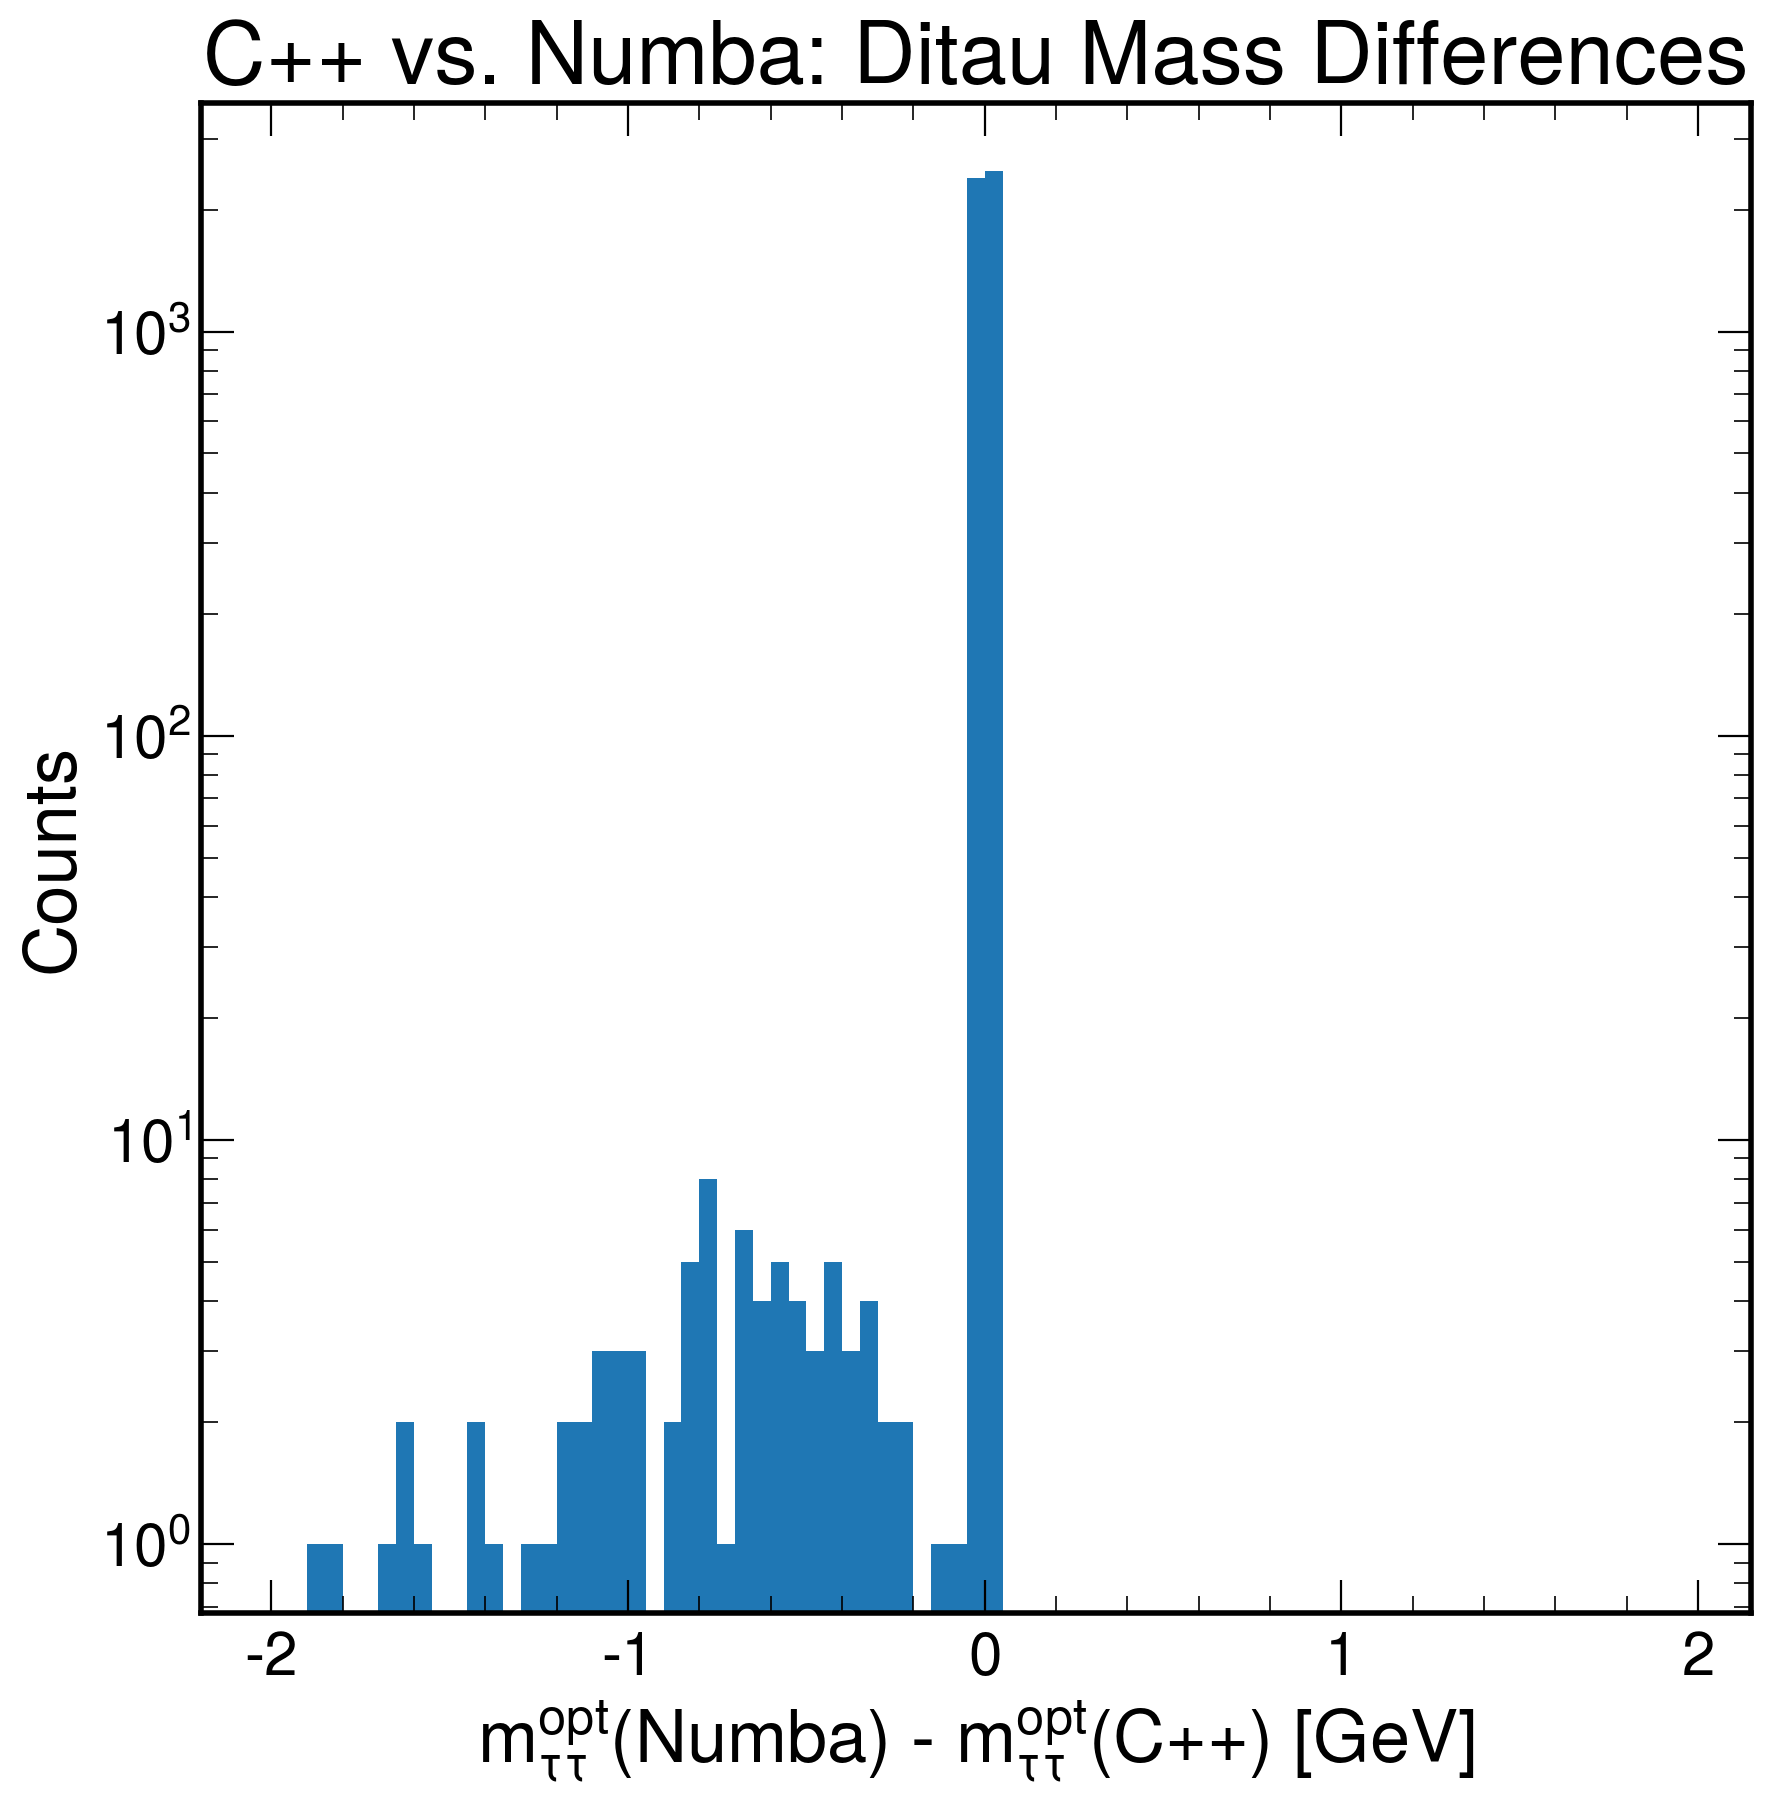

In [15]:
# show the differences in predictions for the ditau mass
diffs = out_numba['m_tt_opt'] - out_classic['m_tt_opt']
differed = (abs(diffs) > 0.1)
fig = plt.figure(dpi=200)
plt.hist(diffs, bins=np.arange(-2, 2, 0.05))
plt.yscale('log')
plt.ylabel("Counts")
plt.xlabel(r"$m_{\tau\tau}^{opt}$(Numba) - $m_{\tau\tau}^{opt}$(C++) [GeV]")
plt.title("C++ vs. Numba: Ditau Mass Differences")
print(f"# events disagreeing by > 0.1: {np.sum(differed)}")
plt.show()